# Machine Learning - Homework 8

In [ ]:
import torch
from torch import nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms
from torchvision import models

In [ ]:
def get_dataset(dataset, path, normalize):
  transform = transforms.Compose([
      transforms.ToTensor(),
      normalize
  ])

  training_set = dataset(
    path,
    train=True,
    transform=transform,
    download=True
  )
  validation_set = dataset(
    path,
    train=False,
    transform=transform,
    download=True
  )

  training_loader = torch.utils.data.DataLoader(
    training_set,
    batch_size=4,
    shuffle=True
  )
  validation_loader = torch.utils.data.DataLoader(
    validation_set,
    batch_size=4,
    shuffle=False,
  )

  return training_set, validation_set, training_loader, validation_loader

def train(
    model,
    train_dataset,
    val_dataset,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    num_epochs
):
    for epoch in range(num_epochs):
        model.train()

        running_loss = 0.0
        running_corrects = 0

        for inputs, labels in train_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        train_loss = running_loss / len(train_dataset)
        train_acc = running_corrects.double() / len(train_dataset)

        model.eval()

        running_loss = 0.0
        running_corrects = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs = inputs.to(device)
                labels = labels.to(device)

                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

        val_loss = running_loss / len(val_dataset)
        val_acc = running_corrects.double() / len(val_dataset)

        print('Epoch [{}/{}], train loss: {:.4f}, train acc: {:.4f}, val loss: {:.4f}, val acc: {:.4f}'
              .format(epoch+1, num_epochs, train_loss, train_acc, val_loss, val_acc))

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Implement a direct convolutional neural network for Fashion MNIST

In [ ]:
class GarmentClassifier(nn.Module):
  def __init__(self):
    super(GarmentClassifier, self).__init__()
    self.conv1 = nn.Conv2d(1, 6, 5)
    self.pool = nn.MaxPool2d(2, 2)
    self.conv2 = nn.Conv2d(6, 16, 5)
    self.fc1 = nn.Linear(16 * 4 * 4, 120)
    self.fc2 = nn.Linear(120, 84)
    self.fc3 = nn.Linear(84, 10)

  def forward(self, x):
    x = self.pool(F.relu(self.conv1(x)))
    x = self.pool(F.relu(self.conv2(x)))
    x = x.view(-1, 16 * 4 * 4)
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.fc3(x)

    return x

cnn_model = GarmentClassifier()

cnn_model.to(device)

train_dataset, val_dataset, train_loader, val_loader = get_dataset(
    torchvision.datasets.FashionMNIST,
    './data/fasion_mnist/',
    transforms.Normalize((0.5,), (0.5,))
)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(cnn_model.parameters(), lr=0.001, momentum=0.9)

train(
    cnn_model,
    train_dataset,
    val_dataset,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    num_epochs=5
)

100%|██████████| 26421880/26421880 [00:01<00:00, 19918711.57it/s]


Extracting ./data/fasion_mnist/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/fasion_mnist/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 300783.29it/s]


Extracting ./data/fasion_mnist/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/fasion_mnist/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:00<00:00, 5532698.11it/s]


Extracting ./data/fasion_mnist/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/fasion_mnist/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 6215393.49it/s]


Extracting ./data/fasion_mnist/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/fasion_mnist/FashionMNIST/raw

Epoch [1/5], train loss: 0.6049, train acc: 0.7739, val loss: 0.4206, val acc: 0.8451
Epoch [2/5], train loss: 0.3701, train acc: 0.8636, val loss: 0.3863, val acc: 0.8611
Epoch [3/5], train loss: 0.3237, train acc: 0.8787, val loss: 0.3268, val acc: 0.8783
Epoch [4/5], train loss: 0.2956, train acc: 0.8899, val loss: 0.3311, val acc: 0.8795
Epoch [5/5], train loss: 0.2749, train acc: 0.8971, val loss: 0.3049, val acc: 0.8912


## Implement a pretrained architecture (e.g. ResNet, Inception) for CIFAR-100

In [ ]:
vgg_model = models.vgg16(pretrained=True)

num_classes = 100
vgg_model.classifier[6] = nn.Linear(in_features=4096, out_features=num_classes)

vgg_model.to(device)

params_to_update_1 = []
params_to_update_2 = []
params_to_update_3 = []

update_param_names_1 = ['features']
update_param_names_2 = ['classifier.0.weight',
                        'classifier.0.bias', 'classifier.3.weight', 'classifier.3.bias']
update_param_names_3 = ['classifier.6.weight', 'classifier.6.bias']

for name, param in vgg_model.named_parameters():
    if update_param_names_1[0] in name:
        param.requires_grad = True
        params_to_update_1.append(param)
    elif name in update_param_names_2:
        param.requires_grad = True
        params_to_update_2.append(param)
    elif name in update_param_names_3:
        param.requires_grad = True
        params_to_update_3.append(param)
    else:
        param.requires_grad = False

train_dataset, val_dataset, train_loader, val_loader = get_dataset(
    torchvision.datasets.CIFAR100,
    './data/cifar100/',
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD([
    {'params': params_to_update_1, 'lr': 1e-4},
    {'params': params_to_update_2, 'lr': 5e-4},
    {'params': params_to_update_3, 'lr': 1e-3}
], momentum=0.9)

train(
    vgg_model,
    train_dataset,
    val_dataset,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    num_epochs=5
)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:10<00:00, 53.9MB/s]


100%|██████████| 169001437/169001437 [00:02<00:00, 80519789.21it/s]


Extracting ./data/cifar100/cifar-100-python.tar.gz to ./data/cifar100/
Files already downloaded and verified
Epoch [1/5], train loss: 2.3063, train acc: 0.3955, val loss: 1.8045, val acc: 0.5041
Epoch [2/5], train loss: 1.5410, train acc: 0.5664, val loss: 1.5343, val acc: 0.5671
Epoch [3/5], train loss: 1.1762, train acc: 0.6556, val loss: 1.4498, val acc: 0.5932
Epoch [4/5], train loss: 0.9088, train acc: 0.7293, val loss: 1.5010, val acc: 0.6023
Epoch [5/5], train loss: 0.6951, train acc: 0.7862, val loss: 1.5086, val acc: 0.6148


## (Optional) Investigate and create a YOLO model for object detection on the data set of your choice

The following code and dataset were fully borrowed from the following GitHub repository (except the last cell): https://github.com/tkshnkmr/frcnn_medium_sample/tree/master

In [ ]:
from google.colab import drive

drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
import os
import torch
import torch.utils.data
import torchvision
from PIL import Image
from pycocotools.coco import COCO
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor


class myOwnDataset(torch.utils.data.Dataset):
    def __init__(self, root, annotation, transforms=None):
        self.root = root
        self.transforms = transforms
        self.coco = COCO(annotation)
        self.ids = list(sorted(self.coco.imgs.keys()))

    def __getitem__(self, index):
        # Own coco file
        coco = self.coco
        # Image ID
        img_id = self.ids[index]
        # List: get annotation id from coco
        ann_ids = coco.getAnnIds(imgIds=img_id)
        # Dictionary: target coco_annotation file for an image
        coco_annotation = coco.loadAnns(ann_ids)
        # path for input image
        path = coco.loadImgs(img_id)[0]["file_name"]
        # open the input image
        img = Image.open(os.path.join(self.root, path))
        # number of objects in the image
        num_objs = len(coco_annotation)

        # Bounding boxes for objects
        # In coco format, bbox = [xmin, ymin, width, height]
        # In pytorch, the input should be [xmin, ymin, xmax, ymax]
        boxes = []
        for i in range(num_objs):
            xmin = coco_annotation[i]["bbox"][0]
            ymin = coco_annotation[i]["bbox"][1]
            xmax = xmin + coco_annotation[i]["bbox"][2]
            ymax = ymin + coco_annotation[i]["bbox"][3]
            boxes.append([xmin, ymin, xmax, ymax])
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        # Labels (In my case, I only one class: target class or background)
        labels = torch.ones((num_objs,), dtype=torch.int64)
        # Tensorise img_id
        img_id = torch.tensor([img_id])
        # Size of bbox (Rectangular)
        areas = []
        for i in range(num_objs):
            areas.append(coco_annotation[i]["area"])
        areas = torch.as_tensor(areas, dtype=torch.float32)
        # Iscrowd
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        # Annotation is in dictionary format
        my_annotation = {}
        my_annotation["boxes"] = boxes
        my_annotation["labels"] = labels
        my_annotation["image_id"] = img_id
        my_annotation["area"] = areas
        my_annotation["iscrowd"] = iscrowd

        if self.transforms is not None:
            img = self.transforms(img)

        return img, my_annotation

    def __len__(self):
        return len(self.ids)


# In my case, just added ToTensor
def get_transform():
    custom_transforms = []
    custom_transforms.append(torchvision.transforms.ToTensor())
    return torchvision.transforms.Compose(custom_transforms)


# collate_fn needs for batch
def collate_fn(batch):
    return tuple(zip(*batch))


def get_model_instance_segmentation(num_classes):
    # load an instance segmentation model pre-trained pre-trained on COCO
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=False)
    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    return model

In [ ]:
# path to your own data and coco file
train_data_dir = "drive/MyDrive/ML/my_data/train"
train_coco = "drive/MyDrive/ML/my_data/my_train_coco.json"

# Batch size
train_batch_size = 1

# Params for dataloader
train_shuffle_dl = True
num_workers_dl = 4

# Params for training

# Two classes; Only target class or background
num_classes = 2
num_epochs = 10

lr = 0.005
momentum = 0.9
weight_decay = 0.005

In [ ]:
import torch

print("Torch version:", torch.__version__)

# create own Dataset
my_dataset = myOwnDataset(
    root=train_data_dir, annotation=train_coco, transforms=get_transform()
)

# own DataLoader
data_loader = torch.utils.data.DataLoader(
    my_dataset,
    batch_size=train_batch_size,
    shuffle=train_shuffle_dl,
    num_workers=num_workers_dl,
    collate_fn=collate_fn,
)


# select device (whether GPU or CPU)
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

# DataLoader is iterable over Dataset
for imgs, annotations in data_loader:
    imgs = list(img.to(device) for img in imgs)
    annotations = [{k: v.to(device) for k, v in t.items()} for t in annotations]
    print(annotations)


model = get_model_instance_segmentation(num_classes)

# move model to the right device
model.to(device)

# parameters
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(
    params, lr=lr, momentum=momentum, weight_decay=weight_decay
)

len_dataloader = len(data_loader)

# Training
for epoch in range(num_epochs):
    print(f"Epoch: {epoch}/{num_epochs}")
    model.train()
    i = 0
    for imgs, annotations in data_loader:
        i += 1
        imgs = list(img.to(device) for img in imgs)
        annotations = [{k: v.to(device) for k, v in t.items()} for t in annotations]
        loss_dict = model(imgs, annotations)
        losses = sum(loss for loss in loss_dict.values())

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        print(f"Iteration: {i}/{len_dataloader}, Loss: {losses}")

Torch version: 2.1.0+cu118
loading annotations into memory...
Done (t=0.81s)
creating index...
index created!


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


[{'boxes': tensor([[ 78., 257., 330., 433.]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'image_id': tensor([2], device='cuda:0'), 'area': tensor([44352.], device='cuda:0'), 'iscrowd': tensor([0], device='cuda:0')}]
[{'boxes': tensor([[216., 188., 381., 358.]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'image_id': tensor([1], device='cuda:0'), 'area': tensor([28050.], device='cuda:0'), 'iscrowd': tensor([0], device='cuda:0')}]
[{'boxes': tensor([[113., 153., 439., 382.]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'image_id': tensor([4], device='cuda:0'), 'area': tensor([74654.], device='cuda:0'), 'iscrowd': tensor([0], device='cuda:0')}]
[{'boxes': tensor([[144.,  78., 487., 342.]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'image_id': tensor([5], device='cuda:0'), 'area': tensor([90552.], device='cuda:0'), 'iscrowd': tensor([0], device='cuda:0')}]
[{'boxes': tensor([[140., 188., 306., 293.]], device='cuda:0'), 'labels': te

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 131MB/s]


Epoch: 0/10
Iteration: 1/6, Loss: 1.4436453580856323
Iteration: 2/6, Loss: 1.3066819906234741
Iteration: 3/6, Loss: 1.141542911529541
Iteration: 4/6, Loss: 0.9733355045318604
Iteration: 5/6, Loss: 0.9259189367294312
Iteration: 6/6, Loss: 0.830791711807251
Epoch: 1/10
Iteration: 1/6, Loss: 0.6766784191131592
Iteration: 2/6, Loss: 0.5737200975418091
Iteration: 3/6, Loss: 0.4607768952846527
Iteration: 4/6, Loss: 0.2943008542060852
Iteration: 5/6, Loss: 0.14934396743774414
Iteration: 6/6, Loss: 0.2855476140975952
Epoch: 2/10
Iteration: 1/6, Loss: 0.22234299778938293
Iteration: 2/6, Loss: 0.18518757820129395
Iteration: 3/6, Loss: 0.35149529576301575
Iteration: 4/6, Loss: 0.42087534070014954
Iteration: 5/6, Loss: 0.10928598046302795
Iteration: 6/6, Loss: 0.19582262635231018
Epoch: 3/10
Iteration: 1/6, Loss: 0.22411534190177917
Iteration: 2/6, Loss: 0.21669606864452362
Iteration: 3/6, Loss: 0.22689993679523468
Iteration: 4/6, Loss: 0.3126702606678009
Iteration: 5/6, Loss: 0.2606283128261566
I

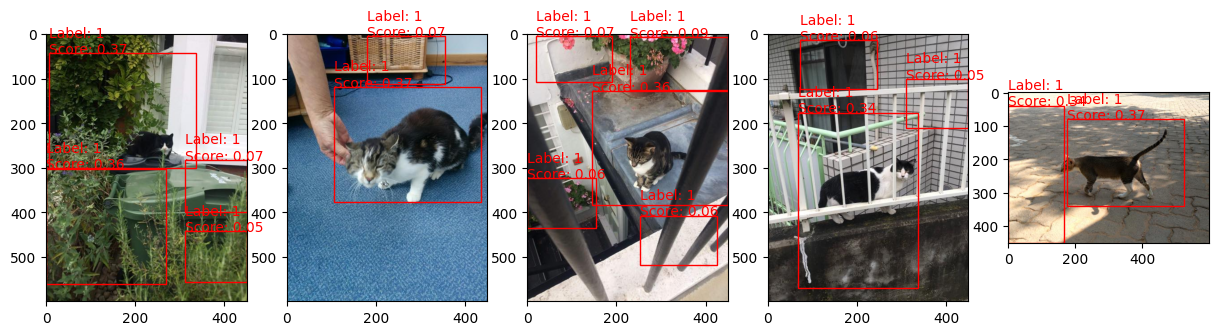

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torchvision.transforms.functional as F
from torchvision.ops import nms

# Set model to evaluation mode
model.eval()

# Visualization function with non-maximum suppression
def visualize_with_nms(imgs, annotations, threshold=0.5):
    fig, axs = plt.subplots(1, len(imgs), figsize=(15, 5))

    for i, (img, annotation) in enumerate(zip(imgs, annotations)):
        img = img.to(device)
        with torch.no_grad():
            prediction = model([img])

        pred_boxes = prediction[0]['boxes'].cpu().numpy().astype(int)
        pred_scores = prediction[0]['scores'].cpu().numpy()
        pred_labels = prediction[0]['labels'].cpu().numpy()

        # Apply non-maximum suppression
        keep = nms(torch.tensor(pred_boxes, dtype=torch.float32), torch.tensor(pred_scores), iou_threshold=threshold)
        pred_boxes = pred_boxes[keep]
        pred_scores = pred_scores[keep]
        pred_labels = pred_labels[keep]

        img_pil = F.to_pil_image(img.cpu())
        axs[i].imshow(np.array(img_pil))

        for j in range(len(pred_boxes)):
            box = pred_boxes[j]
            label = pred_labels[j]
            score = pred_scores[j]
            rect = plt.Rectangle((box[0], box[1]), box[2] - box[0], box[3] - box[1], linewidth=1, edgecolor='r',
                                facecolor='none')
            axs[i].add_patch(rect)
            axs[i].text(box[0], box[1], f'Label: {label}\nScore: {score:.2f}', color='r')

    plt.show()

# Choose a random subset of images for visualization
num_images_to_visualize = 5
visualize_indices = np.random.choice(len(my_dataset), num_images_to_visualize, replace=False)
visualize_imgs = [my_dataset[idx][0] for idx in visualize_indices]
visualize_annotations = [my_dataset[idx][1] for idx in visualize_indices]

# Visualize with non-maximum suppression
visualize_with_nms(visualize_imgs, visualize_annotations, threshold=0.01)